In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load data and handle missings

In [39]:
df_train = pd.read_csv('/testing_data.csv')
df_test = pd.read_csv('/training_data.csv')

In [40]:
y_train = df_train['stroke']
X_train = df_train.drop('stroke',axis=1)
y_test = df_test['stroke']
X_test = df_test.drop('stroke',axis=1)

X_train['bmi'] = X_train['bmi'].fillna(X_train['bmi'].mean())
X_test['bmi'] = X_test['bmi'].fillna(X_test['bmi'].mean())

# Select numeric variables and handle outliers

In [41]:
X_train_numeric = X_train.loc[:,['age','hypertension','heart_disease','bmi','avg_glucose_level'] ]
X_test_numeric = X_test.loc[:,['age','hypertension','heart_disease','bmi','avg_glucose_level'] ]

<Axes: >

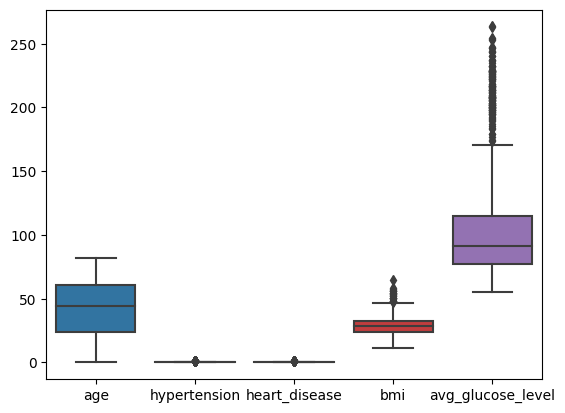

In [6]:
sns.boxplot(X_train_numeric)

<Axes: >

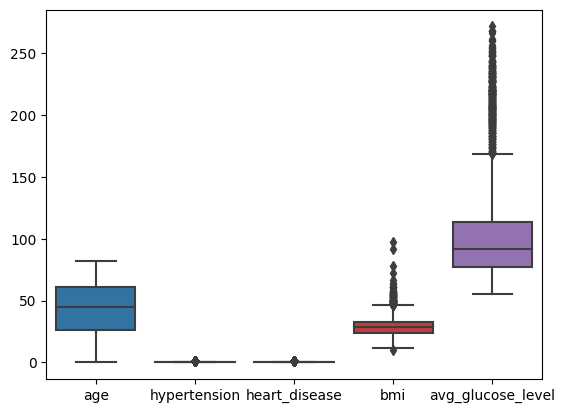

In [7]:
sns.boxplot(X_test_numeric)

In [8]:
## Function to compute whiskers:
def windsorize(x):
    # Compute IQR and 1st,3rd quantiles
    pct25, pct75 = np.percentile(x,[25,75])
    iqr = pct75 - pct25
    # Compute whiskers:
    lower_whisker = pct25 - iqr*1.5
    upper_whisker = pct75 + iqr*1.5
    # Windsorize x:
    x_windsor = x
    x_windsor[ x < lower_whisker ] = lower_whisker
    x_windsor[ x > upper_whisker ] = upper_whisker
    return(x_windsor)

In [42]:
X_train_numeric.apply(windsorize)
X_test_numeric.apply(windsorize)

,age,hypertension,heart_disease,bmi,avg_glucose_level
0,36.0,0,0,32.2,65.87
1,45.0,0,0,25.3,68.66
2,58.0,0,0,30.7,168.67
3,61.0,0,0,27.1,69.88
4,78.0,0,0,30.6,103.86
...,...,...,...,...,...
4082,53.0,0,0,41.5,64.17
4083,76.0,0,0,27.0,168.67
4084,81.0,0,0,23.4,80.13
4085,55.0,0,0,40.0,168.67


<Axes: >

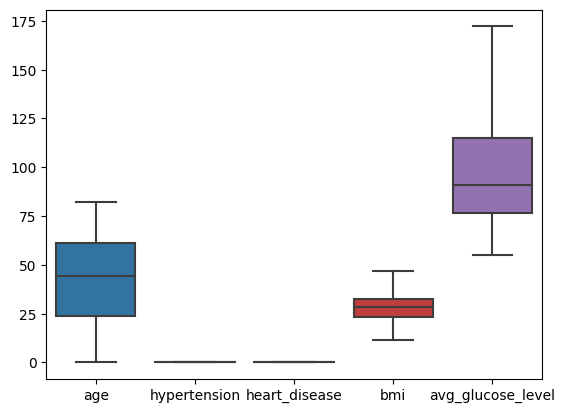

In [10]:
sns.boxplot(X_train_numeric)

<Axes: >

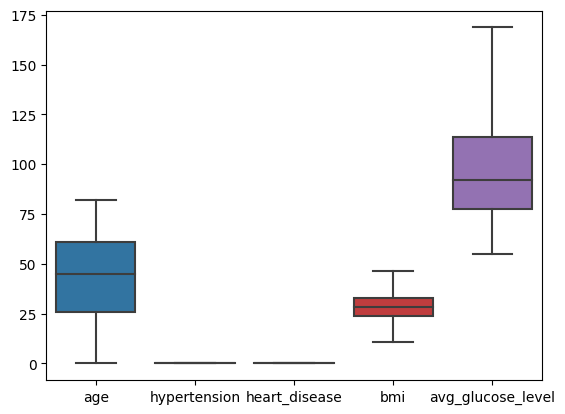

In [11]:
sns.boxplot(X_test_numeric)

# Look at variables

# Create model

In [43]:
from sklearn.linear_model import LinearRegression # Import linear regression model
from sklearn.preprocessing import PolynomialFeatures

Create linear model

In [44]:
expander = PolynomialFeatures(degree=2,include_bias=False) # Create the expander
Z = expander.fit_transform(X_train_numeric) # Pass the df into the expander to get powers/interactions of x and y
names = expander.get_feature_names_out() # Get the names of these variables
continuous = pd.DataFrame(data=Z, columns = names) # Create a new, expanded dataframe
dummies = pd.get_dummies(X_train['smoking_status'],dtype='int',drop_first=True)
Z_train = pd.concat([continuous,dummies],axis=1)

expander = PolynomialFeatures(degree=2,include_bias=False) # Create the expander
Z = expander.fit_transform(X_test_numeric) # Pass the df into the expander to get powers/interactions of x and y
names = expander.get_feature_names_out() # Get the names of these variables
continuous = pd.DataFrame(data=Z, columns = names) # Create a new, expanded dataframe

dummies = pd.get_dummies(X_test['smoking_status'],dtype='int',drop_first=True)
Z_test = pd.concat([continuous,dummies],axis=1)

# Fit the model and get the R2 measure:
reg = LinearRegression().fit(Z_train, y_train) # Fit the linear model
print('R2: ', reg.score(Z_test, y_test)) # R squared measure
y_hat_linear = reg.predict(Z_test)
N = len(y_test)
print('RMSE: ', (np.sum( (y_test - y_hat_linear)**2)/N )**.5 )   # R squared measure

R2:  0.08290790399723624
RMSE:  0.2061064124298083


Create KNN model

In [36]:
from sklearn.neighbors import KNeighborsRegressor as kNNRegression # Import the kNN regression tool

In [45]:
model = kNNRegression(n_neighbors=9)
fitted_model = model.fit(Z_train,y_train)
print('R2: ', reg.score(Z_test, y_test)) # R squared measure
y_hat_knn = fitted_model.predict(Z_test)
N = len(y_test)
print('RMSE: ', (np.sum( (y_test - y_hat_knn)**2)/N )**.5 )   # R squared measure

R2:  0.08290790399723624
RMSE:  0.21252245097514666


Average the predictions

In [46]:
weight_linear = 0.8  # Weight for the linear model's prediction
weight_knn = 0.2  # Weight for the KNN model's prediction

y_hat_combined = (weight_linear * y_hat_linear) + (weight_knn * y_hat_knn)

# Evaluate the combined predictions
rmse_combined = (np.sum( (y_test - y_hat_combined)**2)/N )**.5
print('Combined Model (Averaging) - RMSE:', rmse_combined)

Combined Model (Averaging) - RMSE: 0.20601159631689495


# Plot and visualize results

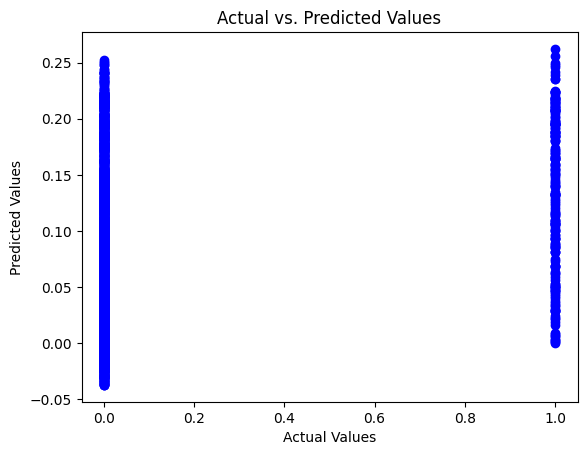

In [48]:
#Plot test against predicted values
plt.scatter(y_test, y_hat_combined, color='blue')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()

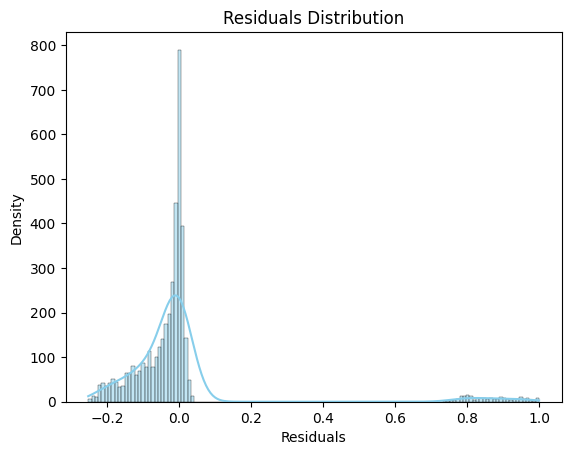

In [49]:
# Compute residuals
residuals = y_test - y_hat_combined

sns.histplot(residuals, kde=True, color='skyblue')
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()